In [75]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Analyse ruggedness for different datasets

In [76]:
from sklearn.manifold import TSNE
import itertools
from functools import partial
import json
import jax.numpy as jnp
import numpy as np
import os
import pandas as pd
import jax
import seaborn as sns
import matplotlib.pyplot as plt
from synbio_morpher.utils.data.data_format_tools.common import load_json_as_dict, write_json
from synbio_morpher.utils.results.analytics.naming import get_true_interaction_cols
from evoscaper.utils.evolution import calculate_ruggedness_from_perturbations


jax.config.update('jax_platform_name', 'cpu')

jax.devices()

[cuda(id=1)]

# Biological resim: dataset 0211

## Add ruggedness to og dataset

In [77]:
fn_ds0211 = 'data/simulate_circuits/2025_02_11__13_56_51/tabulated_mutation_info.json'
dir_ds0211_rug1 = 'data/07_ruggedness/2025_03_05__15_19_07'
dir_ds0211_rug2 = 'data/07_ruggedness/2025_03_06__22_11_21'

data = pd.read_json(fn_ds0211)
analytics1 = load_json_as_dict(os.path.join(dir_ds0211_rug1, 'analytics.json'))
analytics2 = load_json_as_dict(os.path.join(dir_ds0211_rug2, 'analytics.json'))
config = load_json_as_dict(os.path.join(dir_ds0211_rug1, 'config.json'))
hpos = pd.Series(load_json_as_dict(os.path.join(os.path.dirname(config['fn_saves']), 'hpos_all.json')))
resimulate_analytics = config.get('resimulate_analytics', True)
objective_cols = ['Log sensitivity', 'Log precision', 'overshoot', 'response_time']

In [78]:
analytics = {}
for k in analytics1:
    if k in analytics2:
        analytics[k] = np.concatenate([analytics1[k], analytics2[k]])
    else: print(k)

In [79]:
def add_rugg(data: pd.DataFrame, interactions: np.ndarray, objective_cols: list, analytics: dict, resimulate_analytics: bool, eps: float):

    n_samples = interactions.shape[0]
    n_interactions = interactions.shape[1]
    n_perturbs = n_interactions + resimulate_analytics
    species = data['sample_name'].dropna().unique()
    n_species = len(species)

    for k in objective_cols:
        analytic_perturbed = jnp.array(
            analytics[k]).reshape(n_samples, n_perturbs, -1)
        if resimulate_analytics:
            analytic_perturbed = analytic_perturbed[:, :-1, :]
            analytic_og = analytic_perturbed[:, -1, :]
        else:
            analytic_og = np.array(analytics_original[k][:n_samples])

        # If loaded from previous data where not all analytics were saved
        if analytic_perturbed.shape[-1] != analytic_og.shape[-1]:
            analytic_perturbed = analytic_perturbed[..., -analytic_og.shape[-1]:]
        
        analytic_perturbed = analytic_perturbed[..., -n_species:]
        analytic_og = analytic_og[..., -n_species:]

        ruggedness = jax.vmap(partial(calculate_ruggedness_from_perturbations, eps=eps))(
            analytic_perturbed, analytic_og[:, None, :])
        
        data[k + ' ruggedness'] = ruggedness.flatten()
    return data


filt = data['sample_name'] == data['sample_name'].dropna().unique()[-1]
interactions = data[filt][get_true_interaction_cols(
    data, hpos.loc['x_type'], remove_symmetrical=True)].values
n_samples = interactions.shape[0]
analytics_original = {'sensitivity': np.array(data['sensitivity']).reshape(n_samples, len(data['sample_name'].dropna().unique())),
                      'precision': np.array(data['precision']).reshape(n_samples, len(data['sample_name'].unique()))}
eps_perc = config.get('eps_perc', - 1e-2)
eps = eps_perc * np.abs(interactions).max()

data = add_rugg(data, interactions, objective_cols, analytics, resimulate_analytics, eps)


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


<Axes: xlabel='Log ruggedness (Log sensensitivity)', ylabel='Count'>

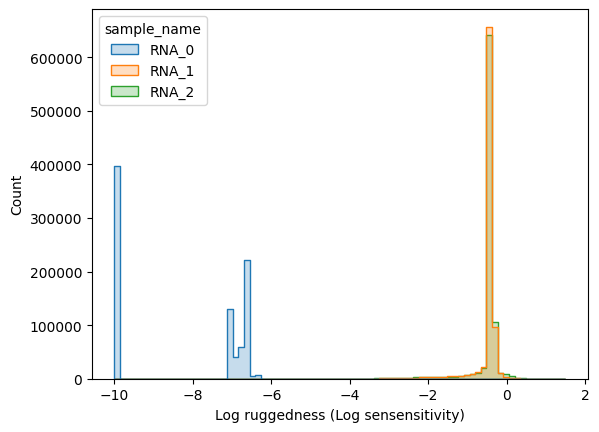

In [91]:
data['Log ruggedness (Log sensensitivity)'] = np.where(data['Log sensitivity ruggedness'] == 0, -10, np.log10(data['Log sensitivity ruggedness']))
sns.histplot(data, x='Log ruggedness (Log sensensitivity)', hue='sample_name', bins=80, element='step')


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


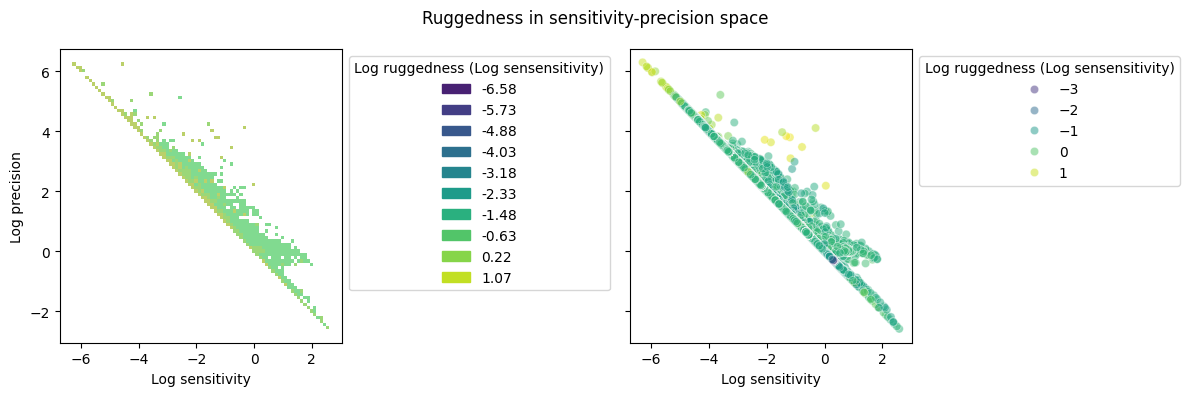

In [ ]:
extra_cols = {}

extra_cols['Log sensitivity ruggedness bin'] = pd.cut(data['Log sensitivity ruggedness'], bins=10).apply(lambda x: np.round(x.mid, 2))
extra_cols['Log ruggedness (Log sensensitivity) bin'] = pd.Series(pd.cut(data['Log ruggedness (Log sensensitivity)'], bins=10)).apply(lambda x: np.round(x.mid, 2))

fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
g = sns.histplot(data, x='Log sensitivity', y='Log precision', hue=extra_cols['Log ruggedness (Log sensensitivity) bin'], bins=80, palette='viridis', ax=axes[0])
sns.move_legend(g, 'upper left', bbox_to_anchor=(1, 1))

g = sns.scatterplot(data[data['sample_name'] == 'RNA_2'], x='Log sensitivity', y='Log precision', hue='Log ruggedness (Log sensensitivity)', palette='viridis', alpha=0.5, ax=axes[1])
# g = sns.scatterplot(data[(data['Log sensitivity'] > 0) & (data['Log precision'] > 0)], x='Log sensitivity', y='Log precision', hue='Log ruggedness (Log sensensitivity)', palette='viridis', alpha=0.5)
sns.move_legend(g, 'upper left', bbox_to_anchor=(1, 1))

plt.suptitle('Ruggedness in sensitivity-precision space')
plt.tight_layout()

In [93]:
write_json(data, fn_ds0211)
